# SALES PREDICTION

# 0 Imports

## 0.0 Import Libs

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

import inflection
import math
import datetime
import random 
import pickle
import json
import requests

from scipy import stats as ss
from boruta import BorutaPy
from IPython.display import Image
from tabulate import tabulate
from sklearn.preprocessing import RobustScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from flask import Flask, request , Response

## 0.1 Functions

In [2]:
def cramer_v (x,y):
    cm =pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2_cor = max( 0 , chi2-(k-1)*(r-1)/(n-1))
    
    k_cor = k - (k-1)**2/(n-1)
    r_cor = r - (r-1)**2/(n-1)   
    return np.sqrt((chi2_cor/n) / (min(k_cor-1,r_cor-1)))


def mean_absolute_percentage_error (y, yhat):
    return np.mean (np.abs((y-yhat)/y)) 


def ml_error (model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({ 'Model Name': model_name,
                          'MAE' : mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0])

def cross_validation (x_training, k_fold, model_name, model_use ):
    mae_list=[]
    mape_list=[]
    rmse_list=[]

    for k in reversed( range(1,k_fold+1) ):
        # Start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = x_training['date'].max() -datetime.timedelta(days = (k-1)*6*7)

        # Filtering dataset 
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training dataset
        xtraining = training.drop(['sales','date'], axis =1)
        ytraining = training['sales']

        # validation dataset
        xvalidation = validation.drop(['sales','date'],axis=1)
        yvalidation = validation['sales']

        # model
        model = model_use.fit(xtraining, ytraining)

        # Prediction
        yhat = model.predict( xvalidation )

        # Performance 
        model_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # Store performance 
        mae_list.append (model_result['MAE'])
        mape_list.append(model_result['MAPE'])
        rmse_list.append(model_result['RMSE'])
    
    return pd.DataFrame({'Model Name' : model_name,
                         'MAE CV' : np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),5).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)}, index =[0])

## 0.1 Loading Data

In [3]:
df_sales_raw = pd.read_csv(r"Data\data\train.csv", low_memory=False)
df_store_raw = pd.read_csv(r'Data\data\store.csv', low_memory=False)
df_raw = pd.merge(df_sales_raw, df_store_raw, how="left", on = "Store")

In [4]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 0.2 Data Info

**Files**

train.csv - historical data including Sales

test.csv - historical data excluding Sales

sample_submission.csv - a sample submission file in the correct format

store.csv - supplemental information about the stores


**Data fields**

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all 

schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is 
participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store


# 1.0 Data Description

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
#Rename columns to snakecase

name_col_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

name_col_new = list(map(snakecase,name_col_old))

df1.columns = name_col_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [8]:
print ("Number of Rows: {}".format(df1.shape[0]))
print ("Number of Columns: {}".format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [9]:
#Change date type from object to datatime

df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

### 1.5.1 Strategy for filling every feature

competition_distance : There is no competition store near distance, so used a big distance to input NA values.

competition_open_since_month : The initial month opening of the competition store is the same as date in that store.

competition_open_since_year : The initial year opening of the competition store is the same as date in that store.

promo2_since_week: The initial date to the continuous promotion (promo2) is the same week as date in that store.

promo2_since_year: The initial date to the continuous promotion (promo2) is the same year as date in that store.

promo_interval: Change NA to zero, createad a feature named is_promo to indicate if the store is actualy using a promotion.

In [11]:
#CompetitionDistance 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x :200000.0 if math.isnan(x) else x) 

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x :x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x :x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x :x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x :x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)

#promo_interval
month_map = {1:'Jan' , 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep' , 10:'Oct', 11:'Nov', 12:'Dez'}
df1['promo_interval'] = df1['promo_interval'].fillna(0)
df1['month_map'] = df1['date'].dt.month.map(month_map) 
df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x : 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 Descriptive Statistical

In [15]:
df1_num = df1.select_dtypes(include = ['int64', 'float64'])
df1_cat = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Atttributes

In [16]:
#Central Tendency - mean, median
df1_mean = pd.DataFrame(df1_num.apply(np.mean)).T
df1_median = pd.DataFrame(df1_num.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis
df1_std = pd.DataFrame(df1_num.apply(np.std)).T
df1_max = pd.DataFrame(df1_num.apply(max)).T
df1_min = pd.DataFrame(df1_num.apply(min)).T
df1_range = pd.DataFrame(df1_num.apply(lambda x: x.max() - x.min())).T
df1_skew = pd.DataFrame(df1_num.apply(lambda x: x.skew())).T
df1_kurt = pd.DataFrame(df1_num.apply(lambda x: x.kurtosis())).T

#concatenate 
num = pd.concat([df1_min, df1_max, df1_range, df1_mean, df1_median, df1_std, df1_skew,df1_kurt]).T.reset_index()
num.columns = (['attributes','min','max','range','mean','median','std','skew','kurtosis'])
num

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Categorical Attributes

In [17]:
df1_cat.apply( lambda x : x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

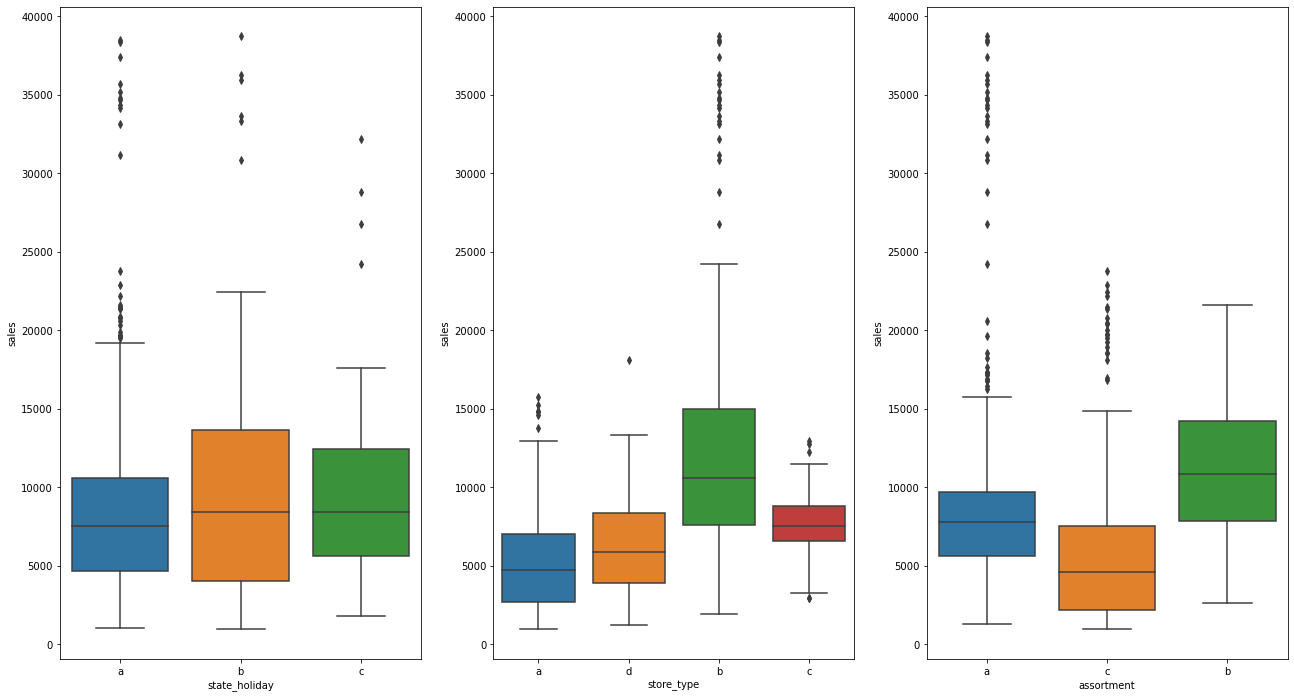

In [18]:
aux1 = df1[(df1['state_holiday']!= '0') & (df1['sales']>0)]

plt.figure(figsize=(22, 12)) 

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday' , y='sales', data = aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data= aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data= aux1)

plt.show()

# 2.0 Feature Engineering

In [19]:
df2 = df1.copy()

## 2.1 Hypotheses Mindmap

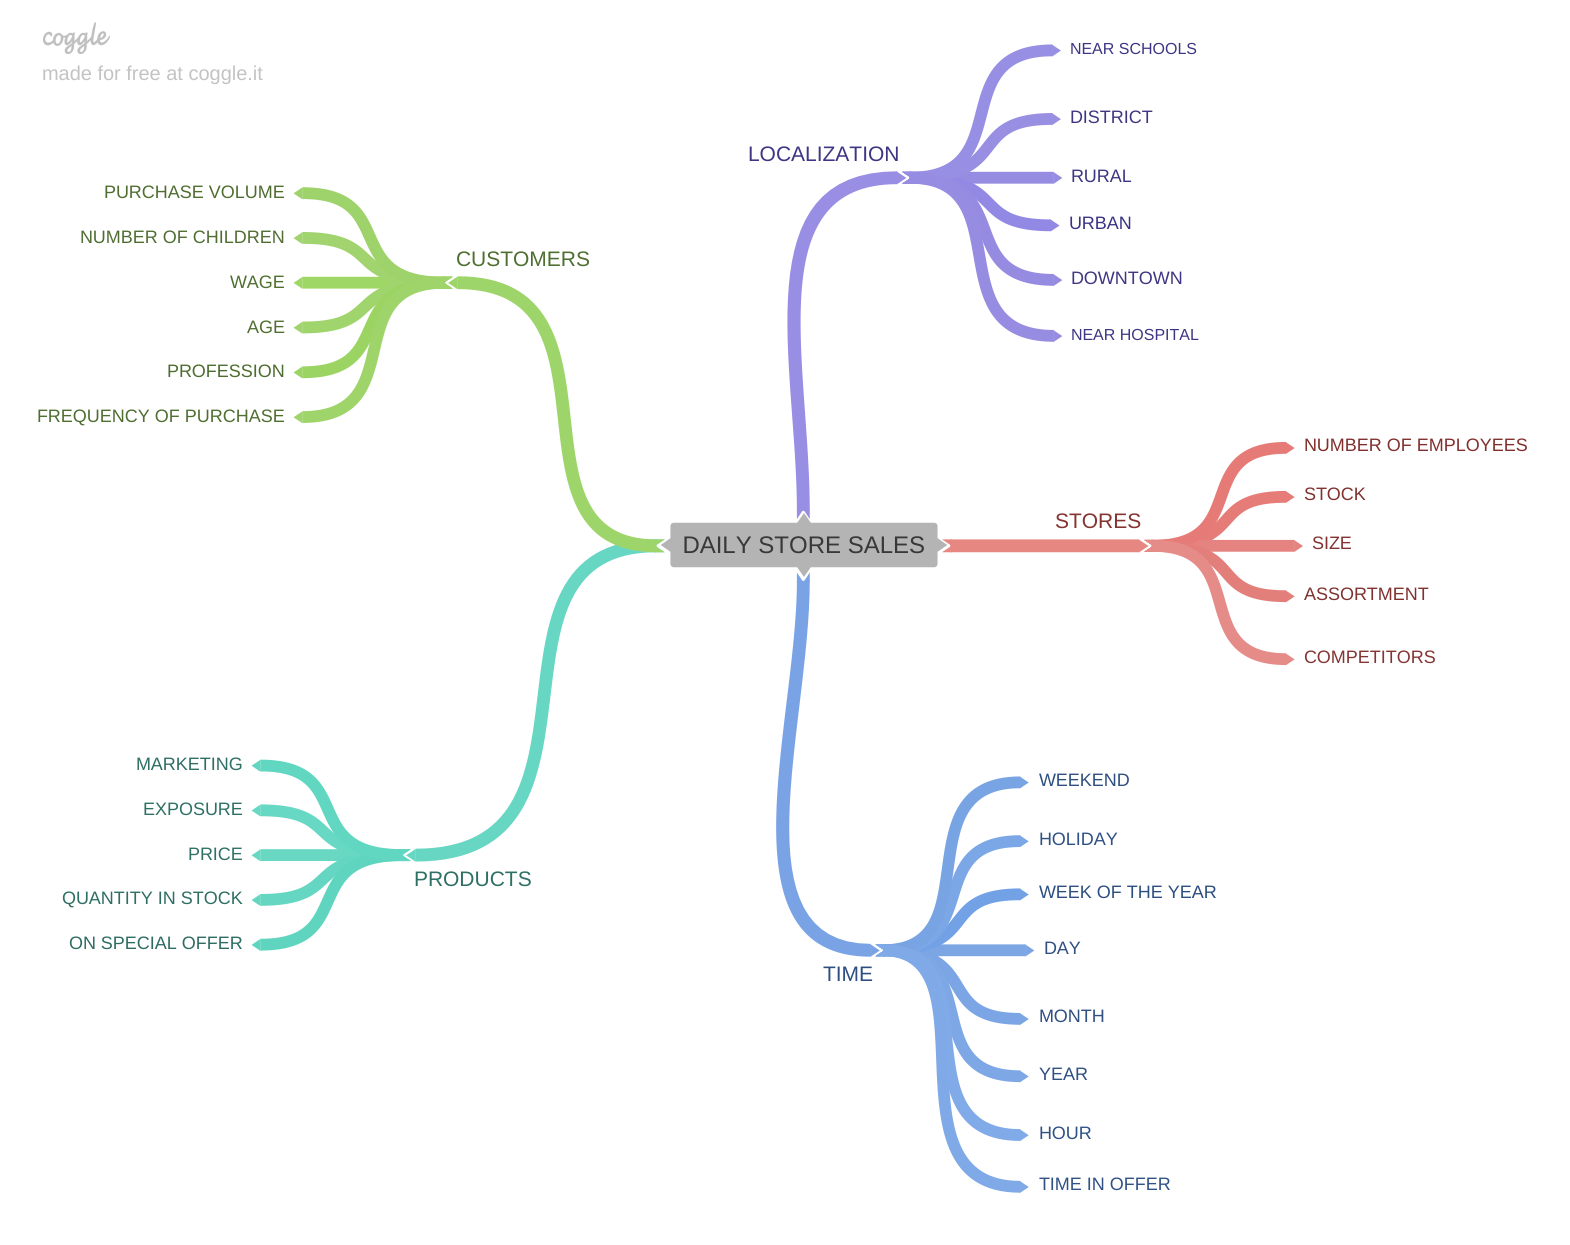

In [20]:
Image(r'Data\images\DAILY_STORE_SALES.PNG', width = 800, height = 600)

## 2.2 Creating Hypothesis

### 2.2.1 Store Hypotesis

**1** Stores with more employees should sell more.
 
**2** Stores with greater stock capacity should sell more.

**3** Larger stores should sell more.

**4** Stores with a larger assortment should sell more.

**5** Stores with closer competitors should sell less.

**6** Stores with longer-term competitors should sell more.

### 2.2.2 Products Hypotesis

**1** Stores that invest more in marketing should sell more.

**2** Stores with greater product exposure sell more. 

**3** Stores with lower product prices should sell more.

**4** Stores with bigger promotions should sell more.

**5** Stores with active promotions for longer sell more.

**6** Stores with more promotion days should sell more.

**7** Stores with more consecutive promotions should sell more.

### 2.2.3 Time Hypotesis

**1** Stores open on Christmas holiday should sell more

**2** Stores should sell more over the years

**3** Stores should sell more in the second half of the year

**4** Stores should sell more after the tenth day of the month

**5** Stores must sell less on weekends

**6** Stores must sell less on school holidays

## 2.3 List of Hyphotesis

**1** Stores with a larger assortment should sell more

**2** Stores with closer competitors should sell less

**3** Stores with longer-term competitors should sell more

**4** Stores with active promotions for longer sell more

**5** Stores with more promotion days should sell more

**6** Stores with more consecutive promotions should sell more

**7** Stores open on Christmas holiday should sell more

**8** Stores should sell more over the years

**9** Stores should sell more in the second half of the year

**10** Stores should sell more after the tenth day of the month

**11** Stores must sell less on weekends

**12** Stores must sell less on school holidays

## 2.3 Feature Engineering

In [21]:
# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# Week of the year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# Year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# Competition since
df2['competition_since']=df2.apply(lambda x : datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'], day=1), axis=1)
df2['competition_since_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype(int)


# Promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x : datetime.datetime.strptime(x +'-1','%Y-%W-%w') - datetime.timedelta( days= 7))
df2['promo_time_week'] = ((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# Assortment
df2['assortment'] = df2['assortment'].apply(lambda x : 'basic' if x == 'a'  else 'extra' if x == 'b' else 'extended')

# State holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x : 'public_holiday' if x == 'a' else 'easter_holiday'if x == 'b' else 'chirstmax' if x =='c' else 'regular_day')

In [22]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Variable Filtering

In [23]:
df3 = df2.copy()

## 3.1 Row filtering

In [24]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Features selection

In [25]:
drop_cols = ['customers','open','promo_interval','month_map']
df3 = df3.drop(drop_cols, axis=1)
df3.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                     int64
month                                    int64
day                                      int64
week_of_year                            UInt32
year_week                               object
competition_s

# 4.0 Exploratory Data Analysis

In [26]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

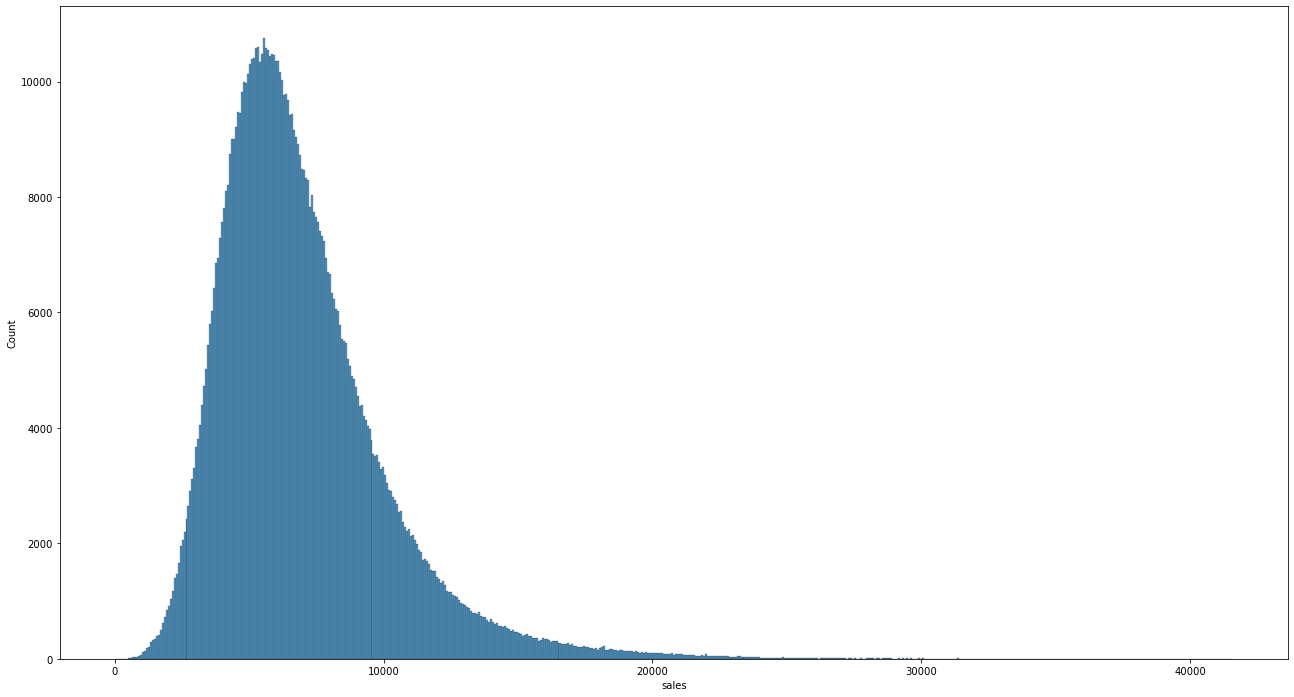

In [27]:
plt.figure(figsize=(22, 12))
sns.histplot(df4['sales']);

### 4.1.2 Numerical Variable

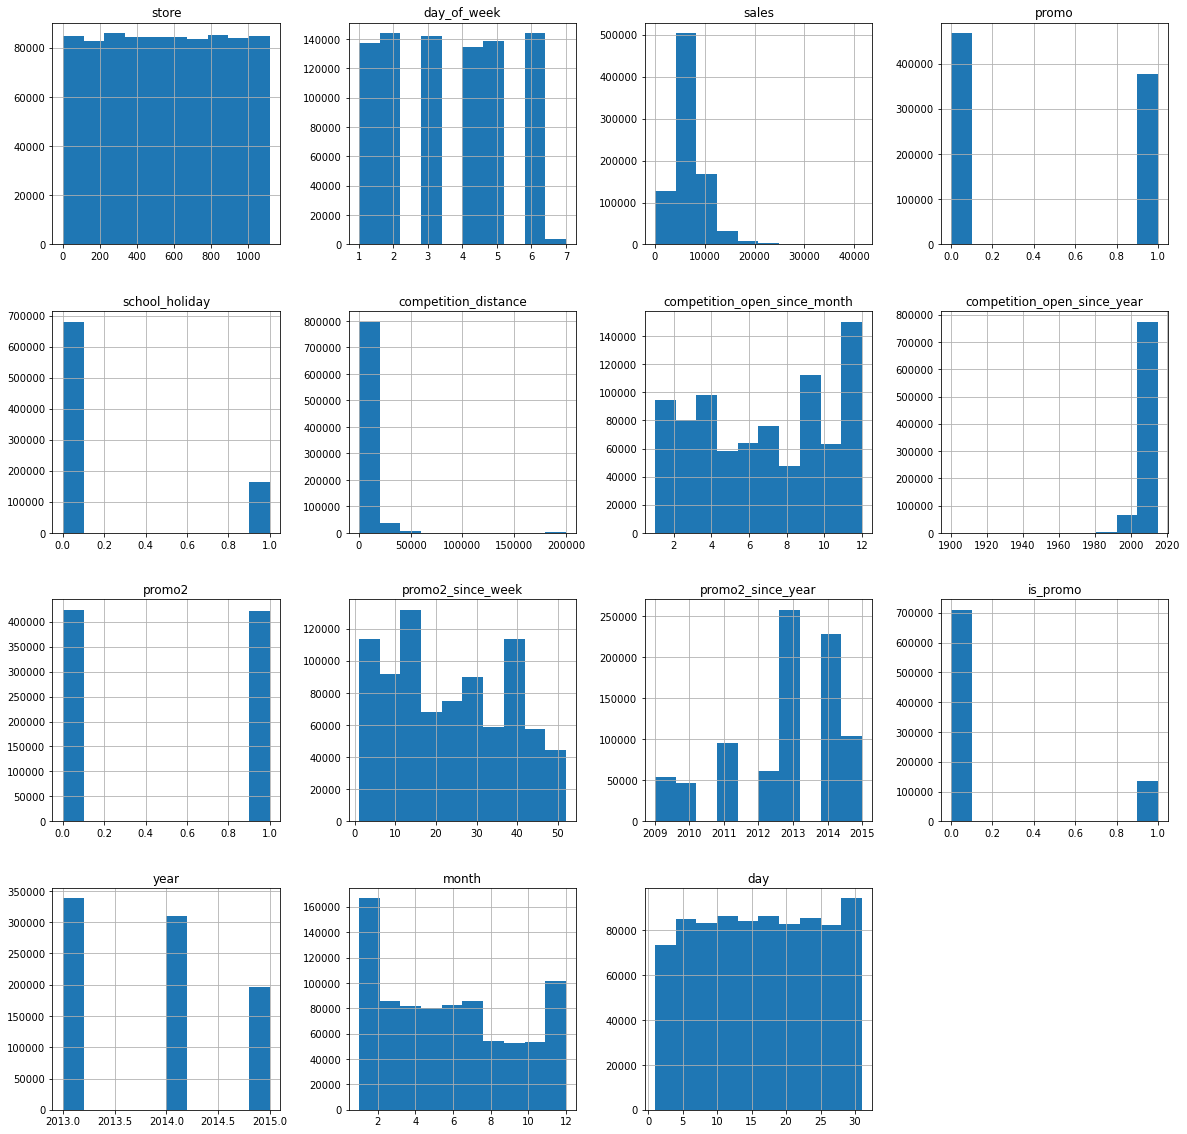

In [28]:
df4_num = df4.select_dtypes(include = ['int64', 'float64'])
df4_num.hist(figsize=(20,20));

### 4.1.3 Categorical Variable 

In [29]:
df4_cat = df4.select_dtypes(include = ['object'])
df4_cat.columns

Index(['state_holiday', 'store_type', 'assortment', 'year_week'], dtype='object')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


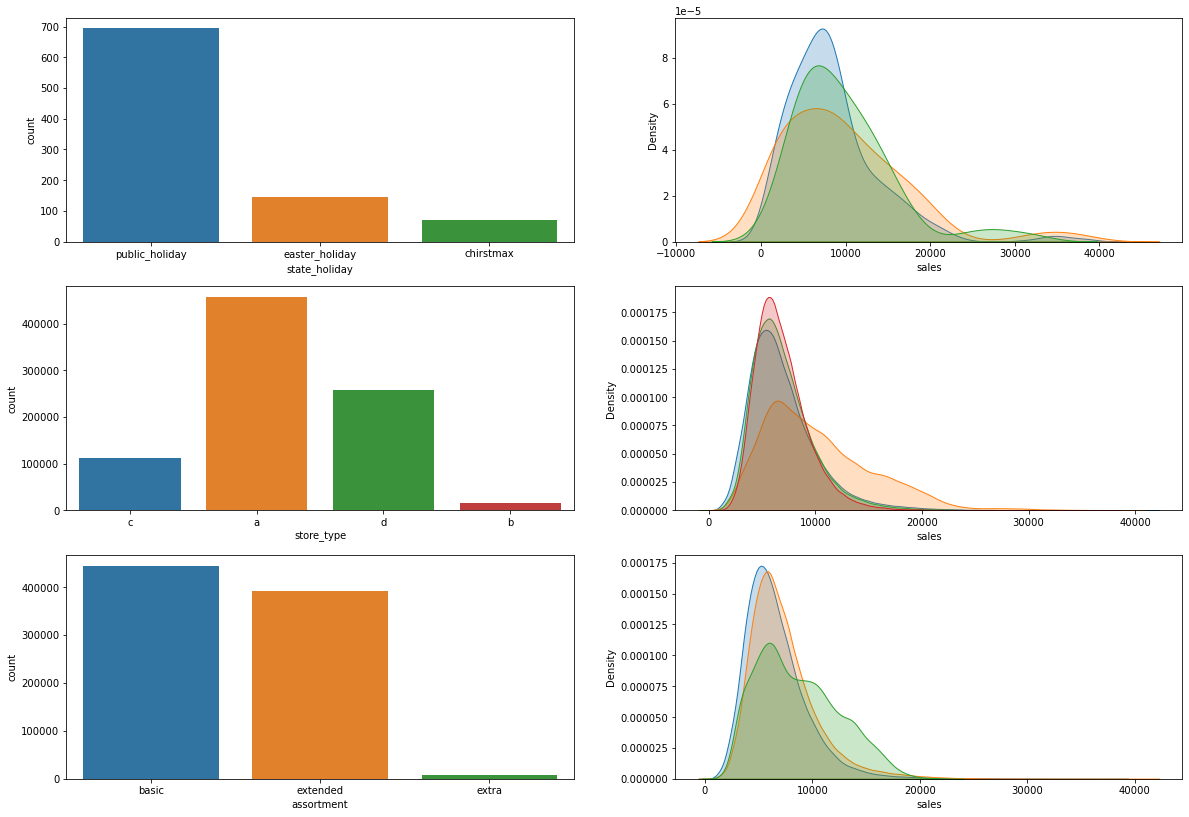

In [30]:
#State Holidays
aux1 = df4_cat[df4_cat['state_holiday'] != 'regular_day']
plt.figure(figsize=(20,14))

plt.subplot(3,2,1)
sns.countplot(aux1['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], shade =True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], shade =True)
sns.kdeplot(df4[df4['state_holiday'] == 'chirstmax']['sales'], shade =True)

#Store type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], shade =True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], shade =True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], shade =True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], shade =True)

#Assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], shade =True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], shade =True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], shade =True);


## 4.2 Bivariate Analysis

### 4.2.1 **H1** Stores with a larger assortment should sell more
**False** Stores with assortment extra or extended sell less

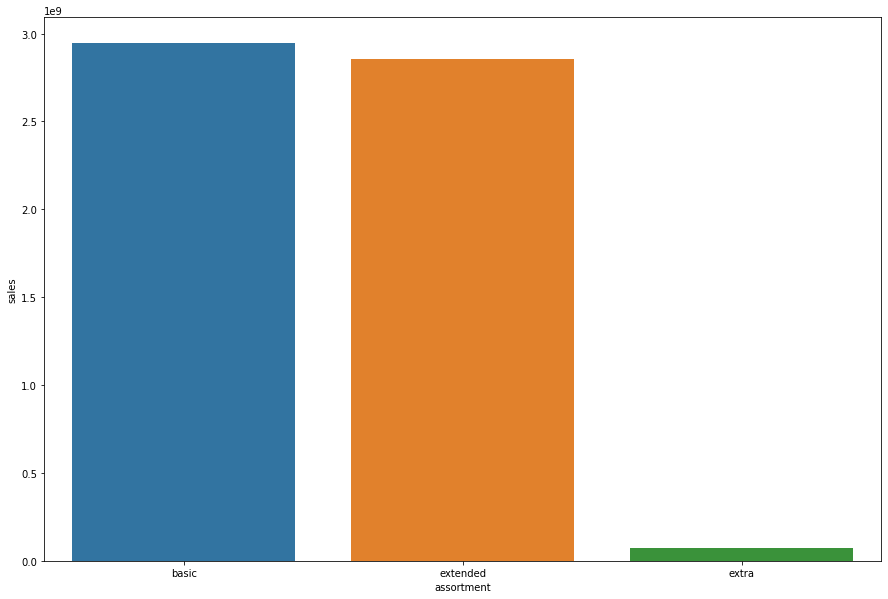

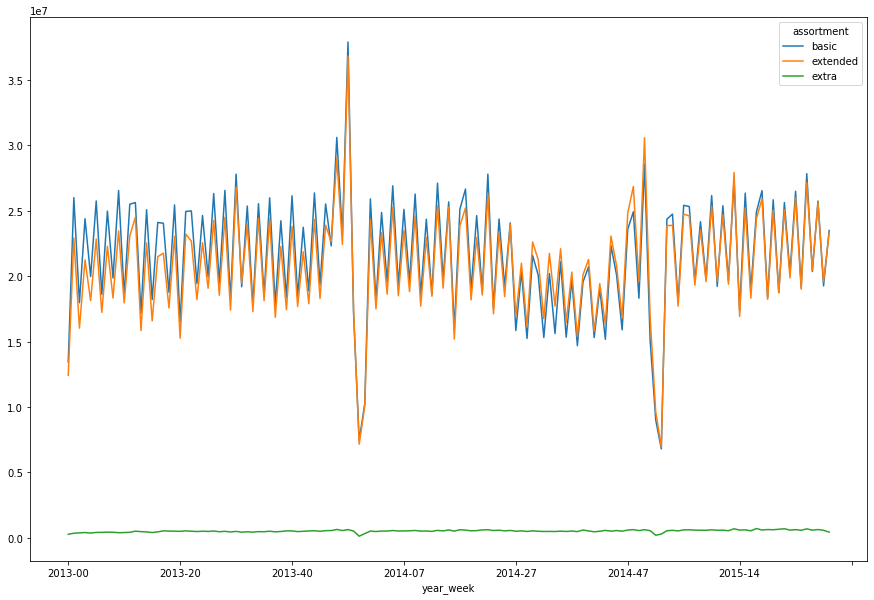

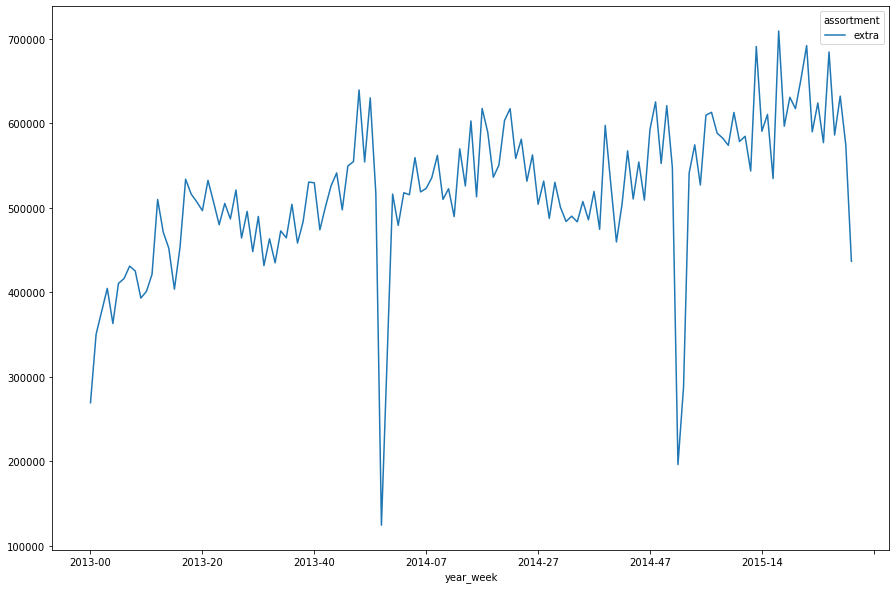

In [31]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
plt.figure(figsize=(15,10))
sns.barplot(x='assortment',y='sales',data=aux1)

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week' , columns='assortment' , values='sales').plot(figsize =(15,10))

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week' , columns='assortment' , values='sales').plot(figsize =(15,10));

### 4.2.2 **H2** Stores with closer competitors should sell less
**False** Stores with closer competitors sell more

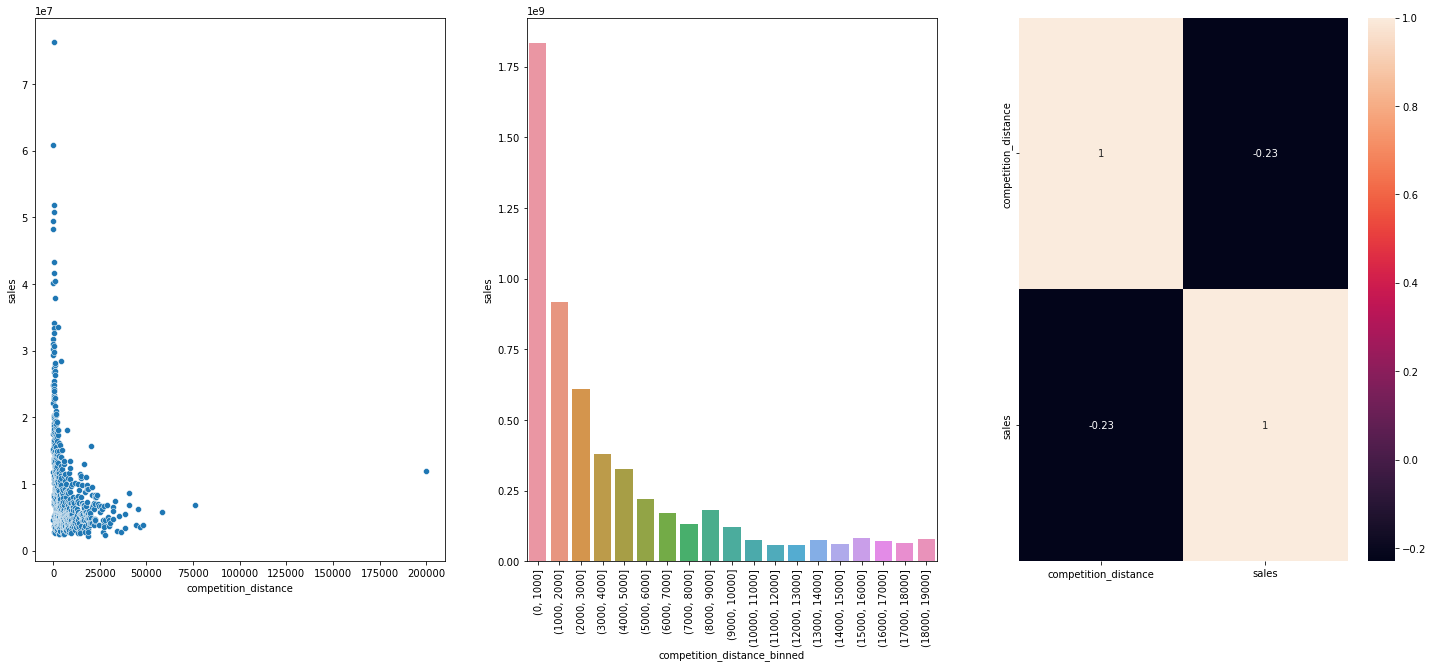

In [32]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

bins= list(np.arange(0, 20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)

aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

plt.figure(figsize=(25,10))
plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.barplot(x='competition_distance_binned',y='sales',data=aux2)
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### 4.2.3 **H3** Stores with longer-term competitors should sell more
**False** Stores with long-term competitors sell less

C:\Users\st_hm\AppData\Local\Temp/ipykernel_6788/1007322397.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux2['competition_since_month_binned'] = pd.cut(aux2['competition_since_month'], bins=bins)


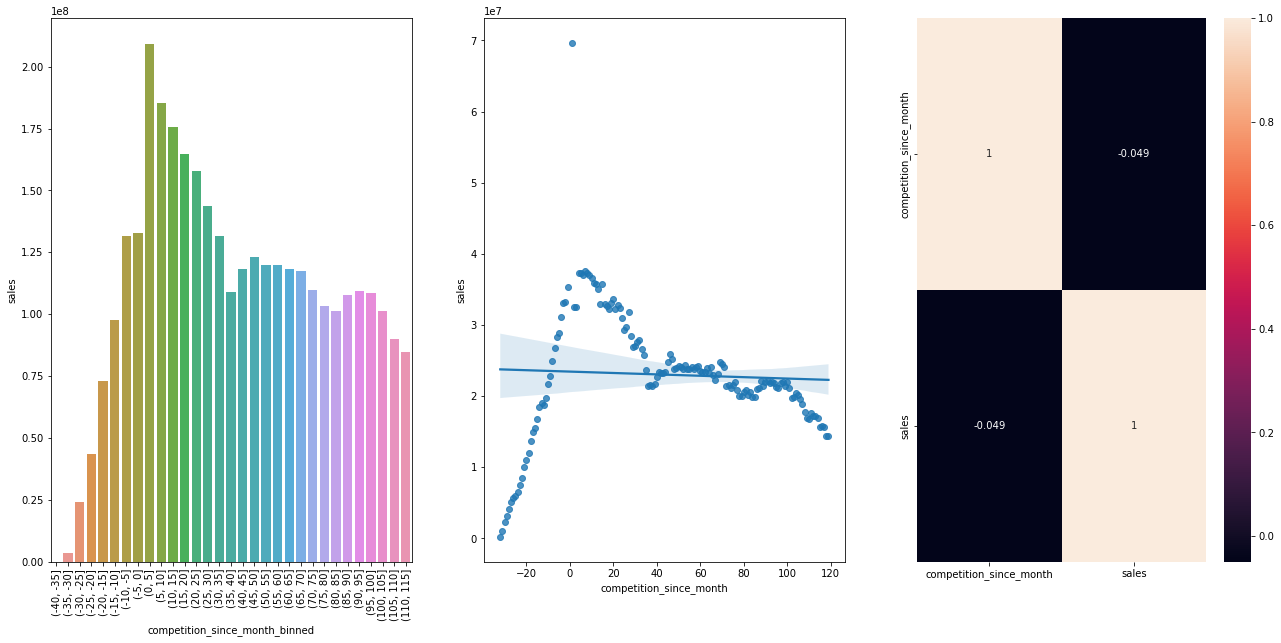

In [33]:
aux1 = df4[['competition_since_month','sales']].groupby('competition_since_month').sum().reset_index()
aux2 = aux1[(aux1['competition_since_month'] <120) & (aux1['competition_since_month'] != 0)]

bins= list(np.arange(-40, 120, 5))
aux2['competition_since_month_binned'] = pd.cut(aux2['competition_since_month'], bins=bins)
aux3 = aux2[['competition_since_month_binned','sales']].groupby('competition_since_month_binned').sum().reset_index()

plt.figure(figsize=(22,10))

plt.subplot(1,3,1)
sns.barplot(x='competition_since_month_binned',y='sales',data=aux3)
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.regplot(x='competition_since_month',y='sales',data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method='pearson'),annot=True);

### 4.2.4 **H4** Stores with active promotions for longer sell more
**False** Stores with longer active promotions sell less, after some time.

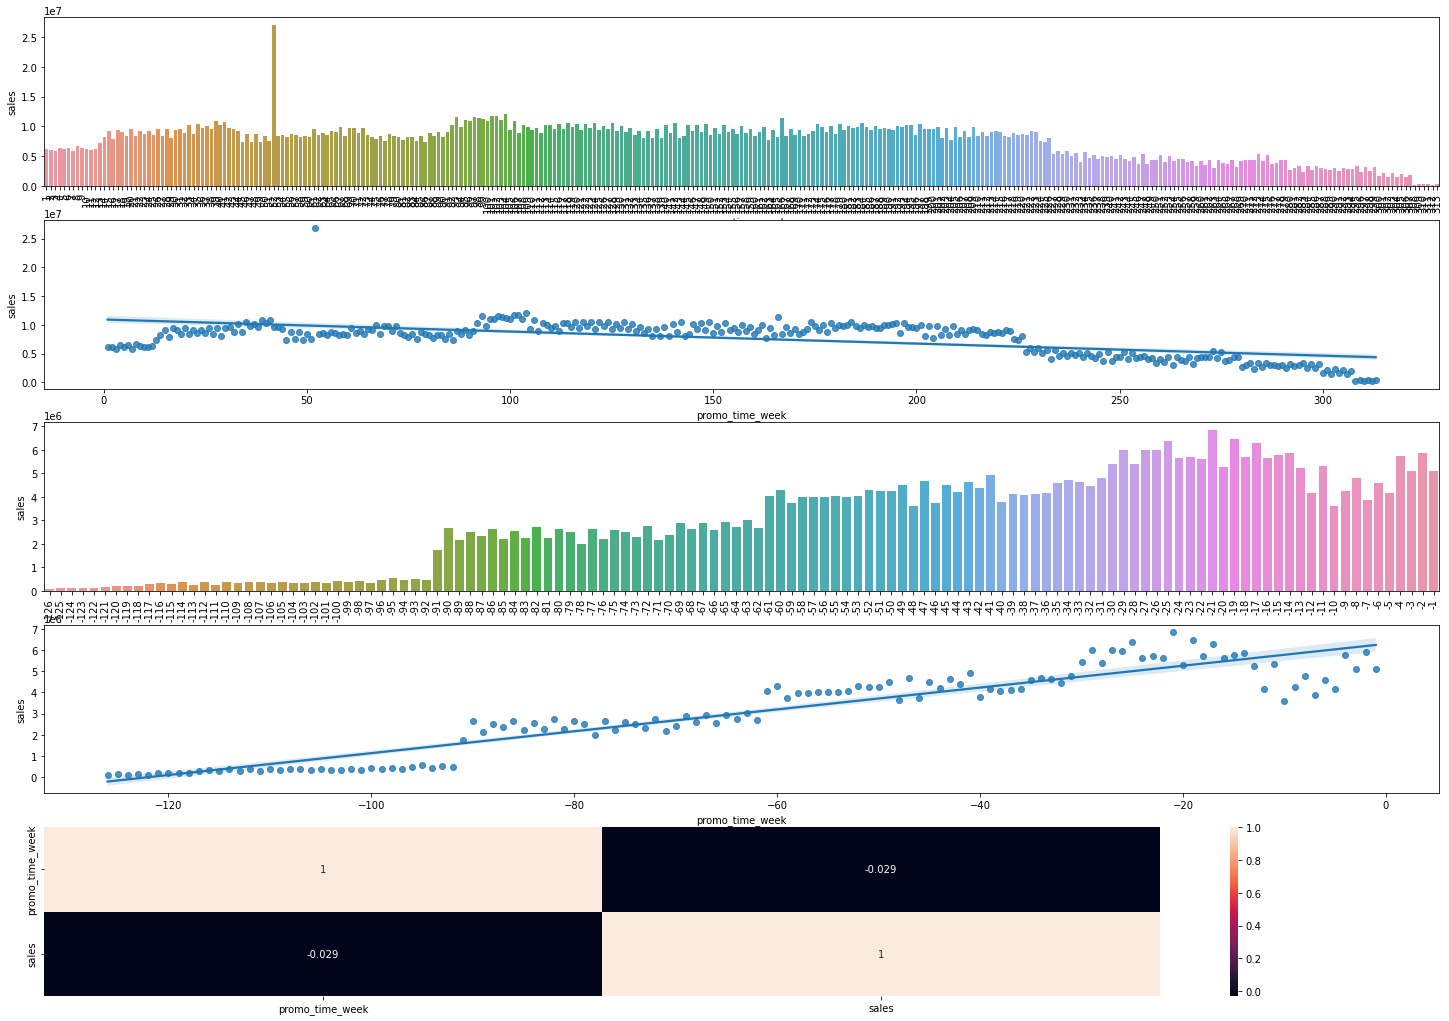

In [34]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

plt.figure(figsize=(25,18))
plt.subplot(5,1,1)
aux2 = aux1[aux1['promo_time_week'] >0]
sns.barplot(x='promo_time_week',y='sales',data=aux2)
plt.xticks(rotation=90)

plt.subplot(5,1,2)
sns.regplot(x='promo_time_week',y='sales',data=aux2)

plt.subplot(5,1,3)
aux3 = aux1[aux1['promo_time_week'] <0]
sns.barplot(x='promo_time_week',y='sales',data=aux3)
plt.xticks(rotation=90);

plt.subplot(5,1,4)
sns.regplot(x='promo_time_week',y='sales',data=aux3)

plt.subplot(5,1,5)
sns.heatmap(aux1.corr(method='pearson'), annot = True);

### <s>4.2.5 **H5** Stores with more promotion days should sell more<s>
**False** Same development from H6 

### 4.2.6 **H6** Stores with more consecutive promotions should sell more
**False** Stores with extended/consecutive promotions sell less

In [35]:
aux1 = df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()
aux1.sort_values('sales', ascending=False)

,promo,promo2,sales
2,1,0,1628930532
0,0,0,1482612096
3,1,1,1472275754
1,0,1,1289362241


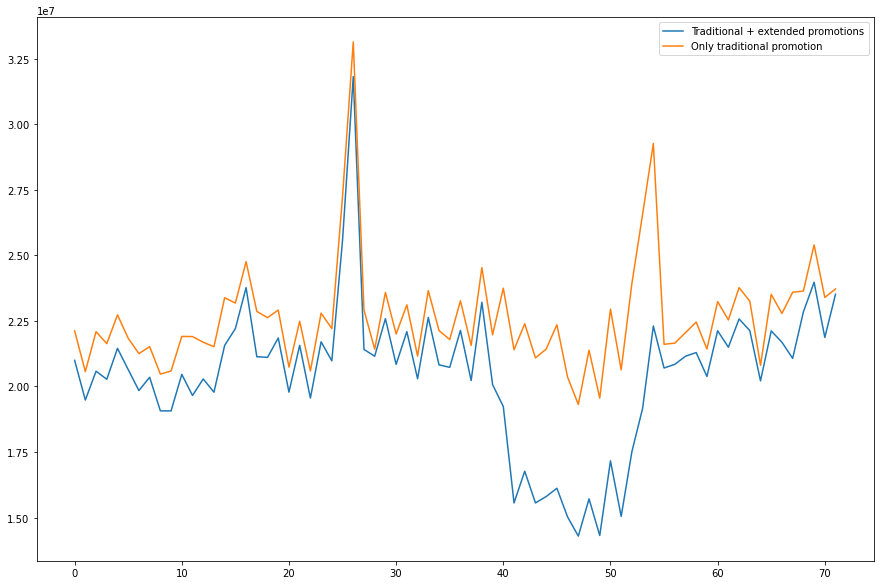

In [36]:
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux2.plot()

aux3 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()

aux3.plot(ax=ax, figsize=(15,10));

ax.legend(labels=['Traditional + extended promotions','Only traditional promotion']);

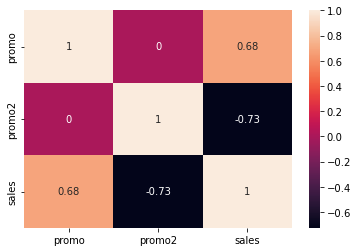

In [37]:
sns.heatmap(aux1.corr(method='pearson'), annot = True);

### 4.2.7 **H7** Stores open on Christmas holiday should sell more
**False** Stores open on Christmas sell less

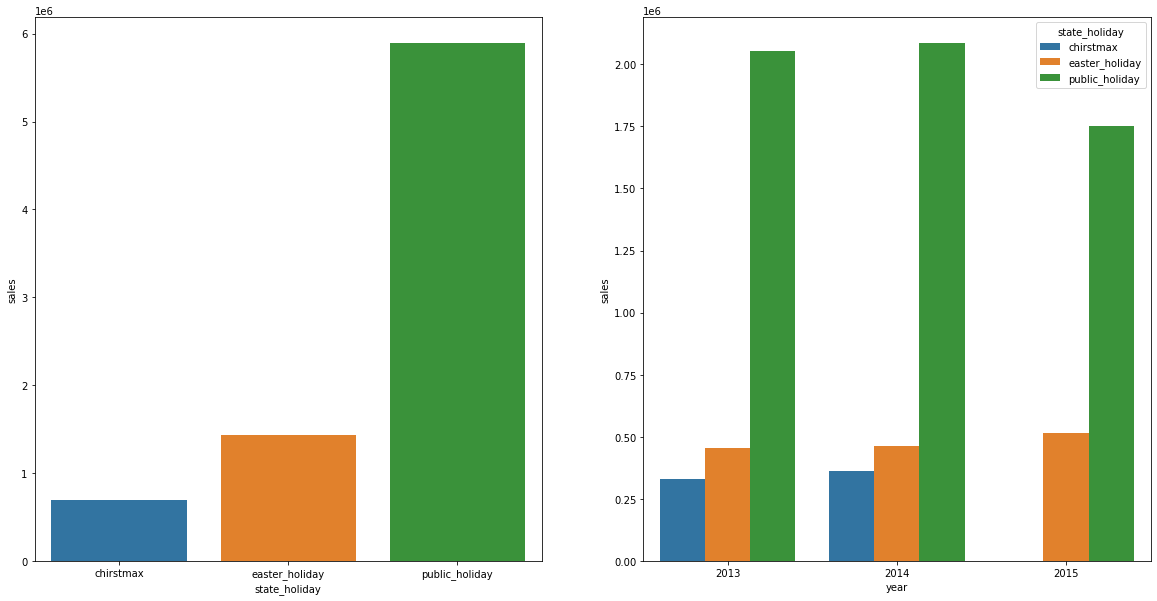

In [38]:
aux1 = df4[df4['state_holiday'] != 'regular_day']
aux2 = aux1[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.barplot(x='state_holiday',y='sales',data= aux2);

aux3 = aux1[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
plt.subplot(1,2,2)
sns.barplot(x='year',y='sales',data=aux3, hue='state_holiday');

### 4.2.8 **H8** Stores should sell more over the years
**False** Stores sell less over the years

<AxesSubplot:>

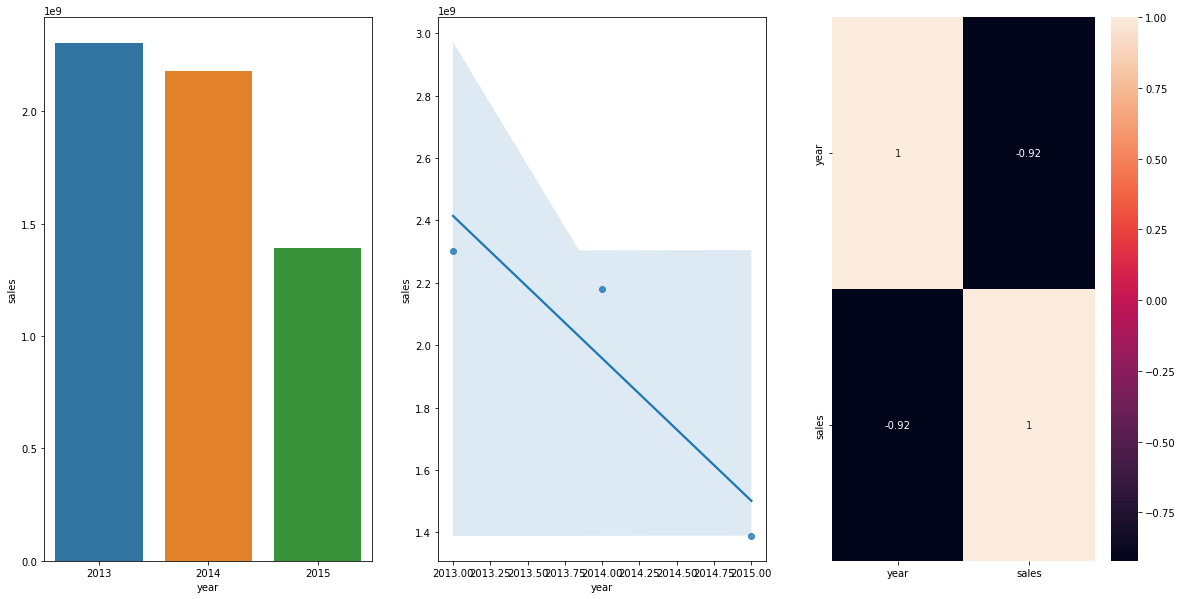

In [39]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
sns.barplot(x='year',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### 4.2.9 **H9** Stores should sell more in the second half of the year
**False** Stores sell less on the second half of the year

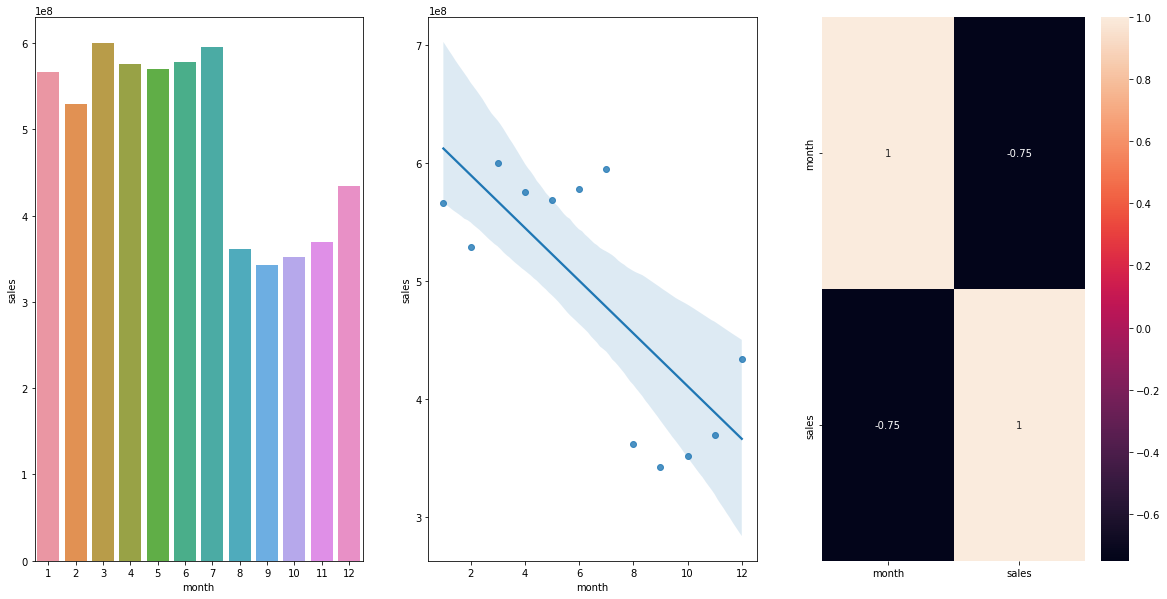

In [40]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
sns.barplot(x='month',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4.2.10 **H10** Stores should sell more after the tenth day of the month
**True** 

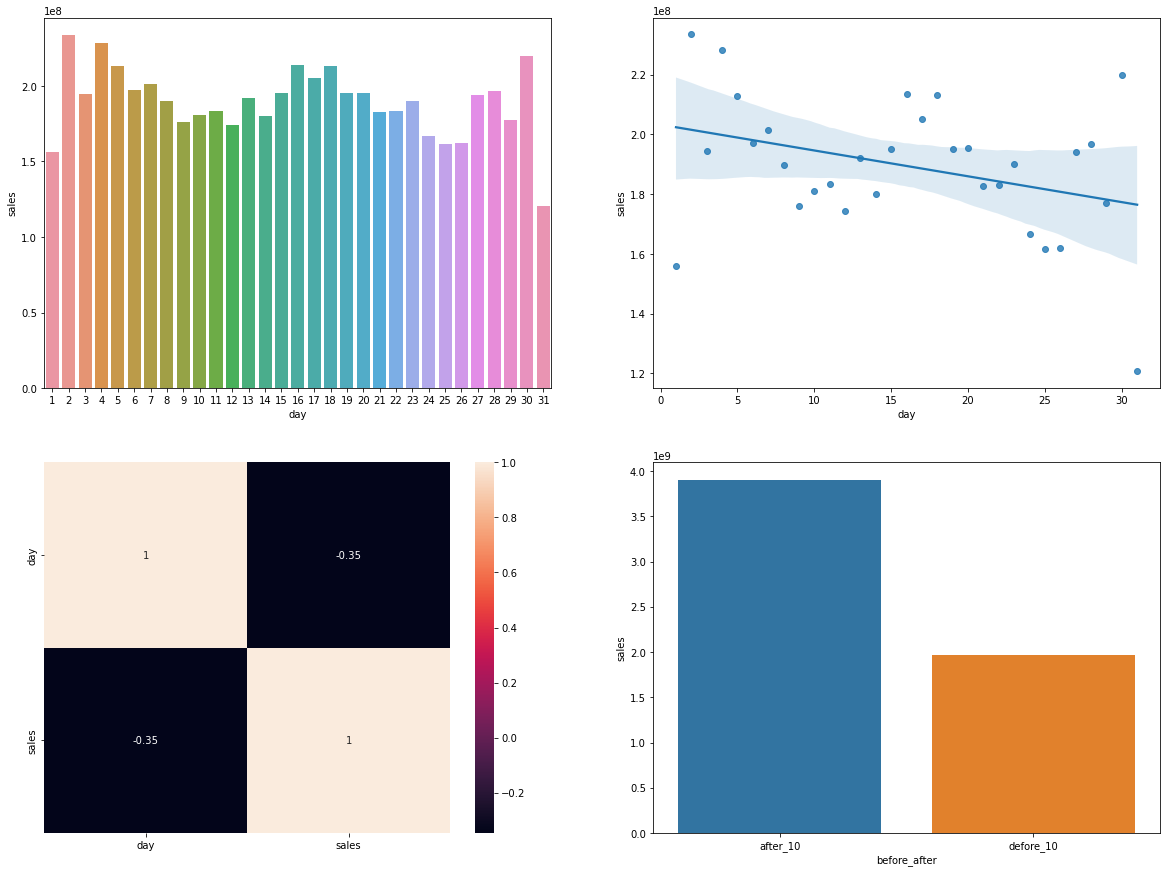

In [41]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(20,15))

plt.subplot(2,2,1)
sns.barplot(x='day',y='sales',data=aux1)

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x : 'defore_10' if x <=10 else 'after_10')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

### 4.2.11 **H11** Stores must sell less on weekends
**True**

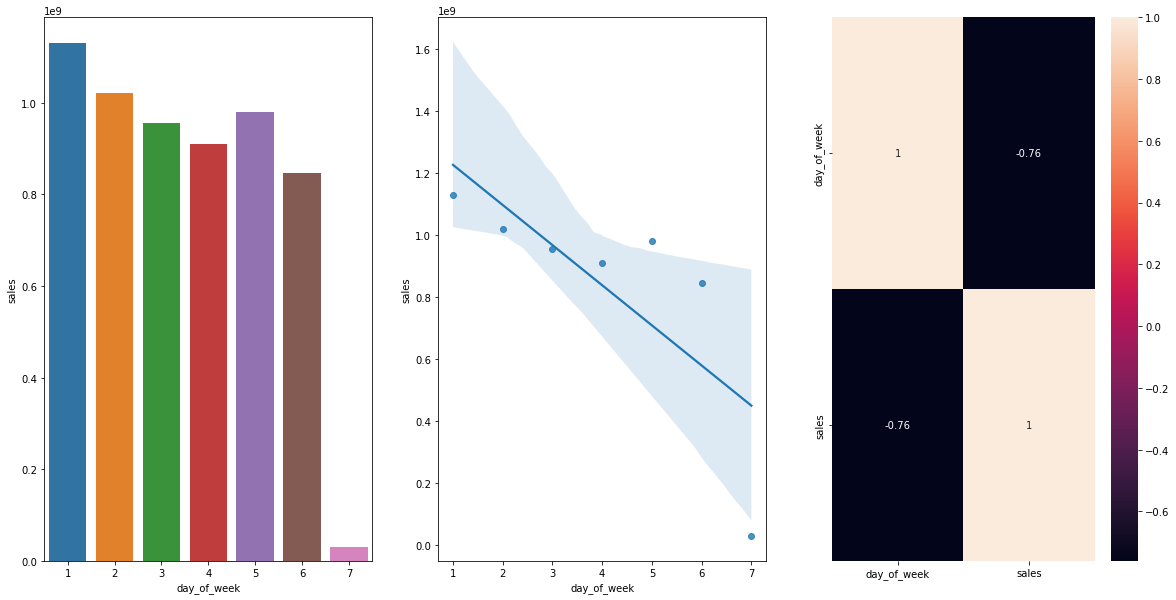

In [42]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
sns.barplot(x='day_of_week',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4.2.12 **H12** Stores must sell less on school holidays
**True**

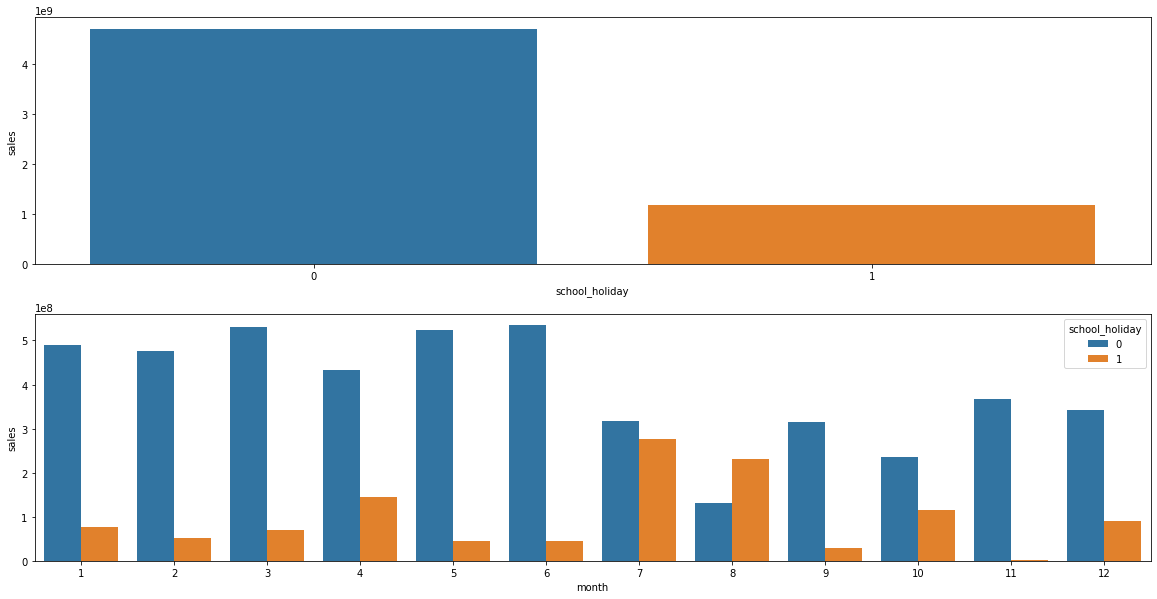

In [43]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
sns.barplot(x='school_holiday',y='sales',data=aux1)

plt.subplot(2,1,2)
aux2 = df4[['school_holiday','month','sales']].groupby(['school_holiday','month']).sum().reset_index()
sns.barplot(x='month',y='sales',data=aux2, hue='school_holiday');

### 4.2.13 Hypotheses Summary

In [44]:
tab=[['Hypothesis','Result'],
    ['H1','False'],
    ['H2','False'],
    ['H3','False'],
    ['H4','False'],
    ['H5','False'],
    ['H6','False'],
    ['H7','False'],
    ['H8','False'],
    ['H9','False'],
    ['H10','False'],
    ['H11','True'],
    ['H12','True'],
    ['H13','True']]
print(tabulate(tab, headers=('firstrow')))

Hypothesis    Result
------------  --------
H1            False
H2            False
H3            False
H4            False
H5            False
H6            False
H7            False
H8            False
H9            False
H10           False
H11           True
H12           True
H13           True


## 4.3 Multivariable Analysis

### 4.3.1 Numerical Attributes

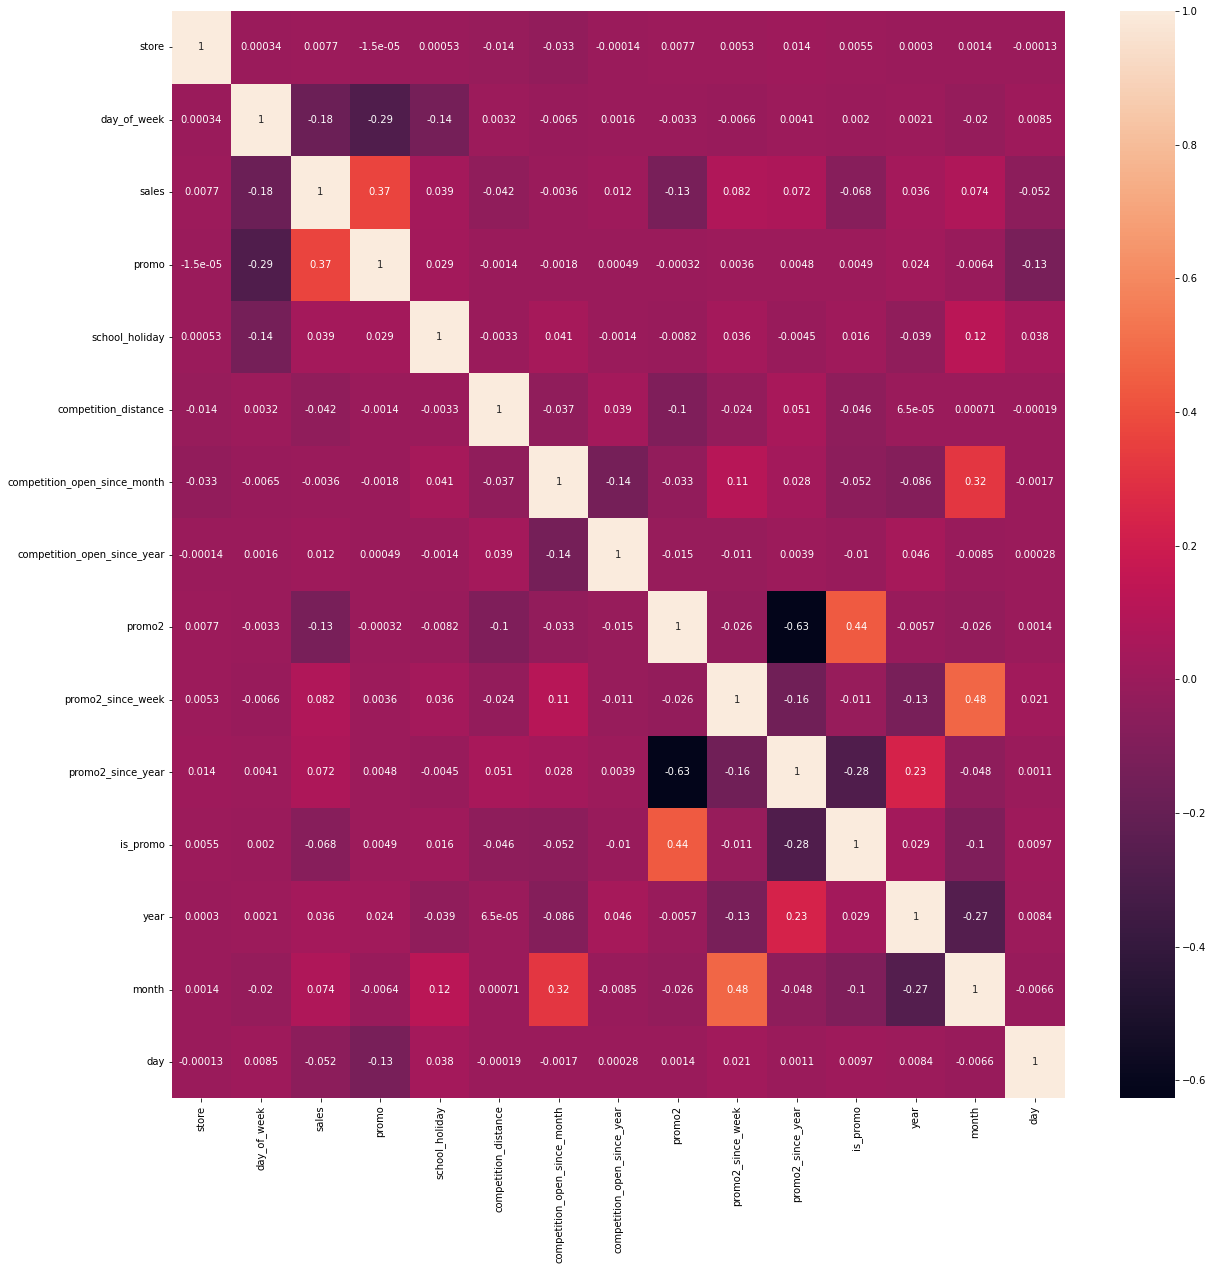

In [45]:
df4_num = df4.select_dtypes(include = ['int64', 'float64'])
plt.figure(figsize=(20,20))
sns.heatmap(df4_num.corr(method='pearson'), annot=True);

### 4.3.2 Categorical Attributes

In [46]:
df4_cat = df4.select_dtypes(include = ['object'])
df4_cat.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


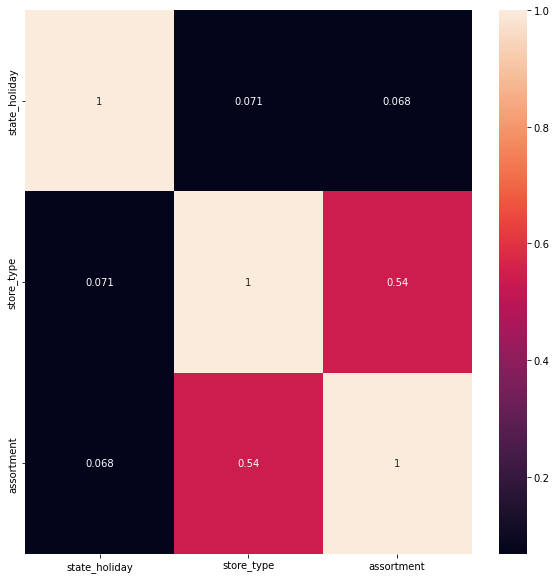

In [47]:
a1 = cramer_v(df4_cat['state_holiday'], df4_cat['state_holiday'])
a2 = cramer_v(df4_cat['state_holiday'], df4_cat['store_type'])
a3 = cramer_v(df4_cat['state_holiday'], df4_cat['assortment'])

a4 = cramer_v(df4_cat['store_type'], df4_cat['state_holiday'])
a5 = cramer_v(df4_cat['store_type'], df4_cat['store_type'])
a6 = cramer_v(df4_cat['store_type'], df4_cat['assortment'])

a7 = cramer_v(df4_cat['assortment'], df4_cat['state_holiday'])
a8 = cramer_v(df4_cat['assortment'], df4_cat['store_type'])
a9 = cramer_v(df4_cat['assortment'], df4_cat['assortment'])

corr_cat = pd.DataFrame({'state_holiday':[a1,a2,a3],
                          'store_type'  :[a4,a5,a6],
                          'assortment'  :[a7,a8,a9]})

corr_cat = corr_cat.set_index(corr_cat.columns)
plt.figure(figsize=(10,10))
sns.heatmap(corr_cat, annot=True);

# 5.0 Data preparation

In [48]:
df5 = df4.copy()

## 5.1 Normalize

Our dataset dont have normal variable, so we will reascaling instead of normalize they.

## 5.2 Rescaling

**Caution** 

Run the complete chapter as it is possible that the graphics will be the same if the copy of the dataframe is updated.

Look for the scale in each grafic.

In [49]:
rs = RobustScaler() # using when variable are heavy in outliers
mms = MinMaxScaler() # using when variable dont have big/much outliers 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


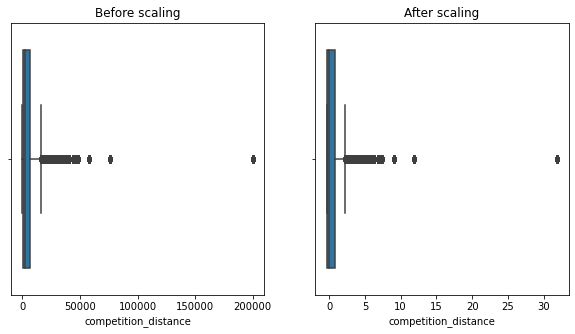

In [50]:
# Competition distance
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Before scaling')
sns.boxplot(df5['competition_distance'])

df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)
pickle.dump( rs , open(r'Data\parameter\competition_distance_scaler.pkl' , 'wb'))
plt.subplot(1,2,2)
plt.title('After scaling')
sns.boxplot(df5['competition_distance']);

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


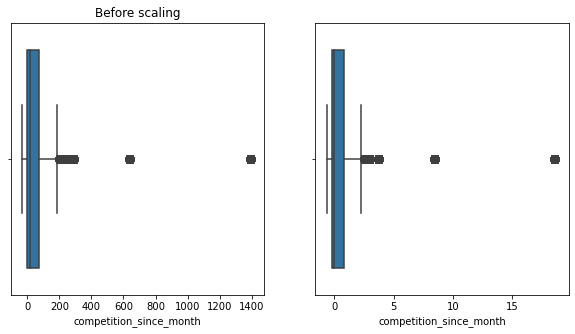

In [51]:
# Competition since month
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Before scaling')
sns.boxplot(df5['competition_since_month']);

plt.subplot(1,2,2)
df5['competition_since_month'] = rs.fit_transform(df5[['competition_since_month']].values)
pickle.dump(rs , open(r'Data\parameter\competition_since_month_scaler.pkl','wb'))
sns.boxplot(df5['competition_since_month']);

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


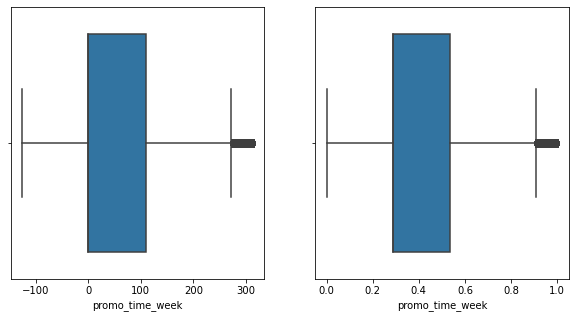

In [52]:
# Promo time week
plt.figure(figsize=(10,5))
plt.title('Before scaling')
plt.subplot(1,2,1)
sns.boxplot(df5['promo_time_week'])

plt.subplot(1,2,2)
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms , open(r'Data\parameter\promo_time_week_scaler.pkl','wb'))
sns.boxplot(df5['promo_time_week']);

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


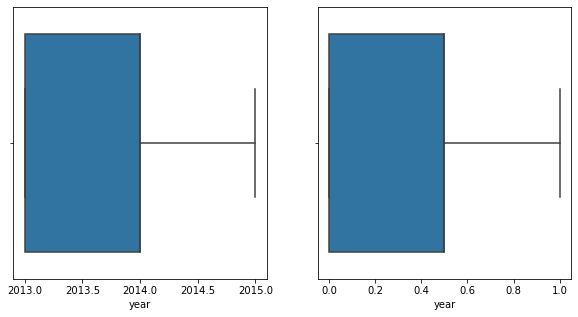

In [53]:
# Year
plt.figure(figsize=(10,5))
plt.title('Before scaling')
plt.subplot(1,2,1)
sns.boxplot(df5['year'])

plt.subplot(1,2,2)
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms , open(r'Data\parameter\year_scaler.pkl','wb'))
sns.boxplot(df5['year']);

## 5.3 Transform

### 5.3.1 Encoding

In [54]:
# State Holiday - One hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'],columns=['state_holiday'])
df5[['state_holiday_chirstmax','state_holiday_easter_holiday','state_holiday_public_holiday','state_holiday_regular_day']].head(2)

,state_holiday_chirstmax,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,0,0,0,1
1,0,0,0,1


In [55]:
# Store type - Label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open(r'Data\parameter\store_type_scaler.pkl','wb'))
df5[['store_type']].head()

,store_type
0,2
1,0
2,0
3,2
4,0


In [56]:
# Assortment - Ordinal encoding
assortment_dict={'basic' : 1 , 'extra' : 2 , 'extended' : 3 }
df5['assortment'] = df5['assortment'].map(assortment_dict)
df5[['assortment']].head()

,assortment
0,1
1,1
2,1
3,3
4,1


### 5.3.2 Response Variable Transformation

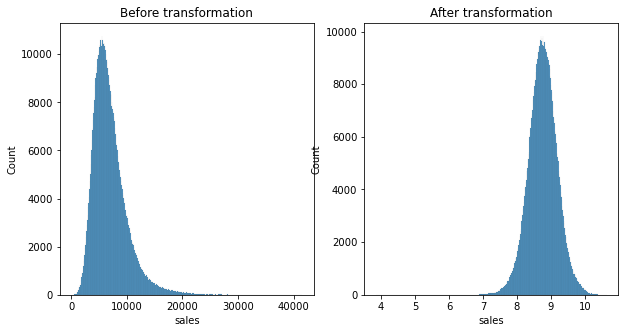

In [57]:
# Sales - Log Transform
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Before transformation')
sns.histplot(df5['sales'])

plt.subplot(1,2,2)
plt.title('After transformation')
df5['sales'] = np.log1p(df5['sales'])
sns.histplot(df5['sales']);

### 5.3.3 Nature Transformation

In [58]:
# Transform linear variable into cyclic variables
# Day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x : np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x : np.cos(x * (2. * np.pi/7)))

# Month
df5['month_sin'] = df5['month'].apply(lambda x : np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x : np.cos(x * (2. * np.pi/12)))

# Day
df5['day_sin'] = df5['day'].apply(lambda x : np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x : np.cos(x * (2. * np.pi/30)))

# Week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x : np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x : np.cos(x * (2. * np.pi/52)))

# 6.0 Feature Selection

In [59]:
df6 = df5.copy()

In [60]:
drop_cols = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(drop_cols, axis=1)

## 6.1 Split Dataframe into traning and test

In [61]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [62]:
# Traning dataset
X_train = df6[df6['date'] < "2015-06-19"]
Y_train = X_train['sales']

# Test dataset
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

print('Traning Min Date {}'.format(X_train['date'].min()))
print('Traning Max Date {}'.format(X_train['date'].max()))

print('\nTest Min Date {}'.format(X_test['date'].min()))
print('Test Max Date {}'.format(X_test['date'].max()))

Traning Min Date 2013-01-01 00:00:00
Traning Max Date 2015-06-18 00:00:00

Test Min Date 2015-06-19 00:00:00
Test Max Date 2015-07-31 00:00:00


## 6.2 Applying Boruta

In [63]:
## Traning and test datasets for boruta
#X_train_b = X_train.drop(['date','sales'], axis=1).values
#Y_train_b = Y_train.values.ravel()
#
## Defining boruta method of split
#rf = RandomForestRegressor(n_jobs=-1)
#
## Denfine boruta
#boruta = BorutaPy(rf , n_estimators='auto' , verbose=2 , random_state = 108).fit(X_train_b, Y_train_b)

In [64]:
#cols_selected = boruta.support_.tolist()
#
## Best Features
#X_train_fs = X_train.drop(['date','sales'], axis=1)
#cols_selected_b = X_train_fs.iloc[:,cols_selected].columns.to_list()
#
## Not selected 
#cols_not_selected_b = list(np.setdiff1d(X_train_fs.columns, cols_selected_b))

In [65]:
#cols_selected_b

In [66]:
#cols_not_selected_b

In [67]:
boruta_selected_list = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2',
 'promo2_since_week', 'promo2_since_year', 'competition_since_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_cos']

In [68]:
boruta_not_selected_list = ['is_promo', 'month_sin', 'school_holiday', 'state_holiday_chirstmax', 'state_holiday_easter_holiday', 'state_holiday_public_holiday',
 'state_holiday_regular_day', 'week_of_year_sin', 'year']

In [69]:
# Including sine for week and month features, date and sales
complementar_feat = ['week_of_year_sin','month_sin']

boruta_selected_list.extend(complementar_feat)
selected_cols = boruta_selected_list
selected_cols

# Including Date and Sales for future use.
other_to_add = [ 'date','sales']
selected_cols_full = selected_cols.copy()
selected_cols_full.extend(other_to_add)

# 7.0 Machine Learning Modeling

In [70]:
df7 = df6.copy()

In [71]:
X_train = df7[df7['date'] < "2015-06-19"]
x_train = X_train[selected_cols]

In [72]:
y_train = X_train['sales']

In [73]:
X_test = df7[df7['date'] >= '2015-06-19']
x_test = X_test[selected_cols]

In [74]:
y_test = X_test['sales']

In [75]:
# Data series cross validation preparation
x_training = df7[selected_cols_full]

## 7.1 Average Model - Line Base

In [76]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

# Prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns ={'sales':'predictions'}) 
aux3 = pd.merge(aux1,aux2,how='left', on='store')
yhat_baseline = aux3['predictions']

# Performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [77]:
# Model 
lr = LinearRegression().fit(x_train, y_train)

# Prediction
yhat_lr = lr.predict( x_test )

# Performance
lr_result = ml_error('Linear Regression' , np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression - Cross Validation

In [78]:
lr_result_cv = cross_validation (x_training, 5, 'Linear Regressor', lr )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regressor,1927.38 +/- 95.66,0.3 +/- 0.01531,2724.56 +/- 179.52


## 7.3 Linear Regression Regulazired Model - Lasso

In [79]:
# Model
lrr = Lasso( alpha = 0.01 ).fit(x_train, y_train)

# Prediction
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_result = ml_error('Linear Regression Regularized', np.expm1(y_test), np.expm1(yhat_lrr)) 
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized,1891.704881,0.289106,2744.451741


### 7.3.1 Linear Regression Regulazired - Cross Validation

In [80]:
lrr_result_cv = cross_validation (x_training, 5, 'Linear Regressor Regularized', lrr )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regressor Regularized,1947.16 +/- 132.37,0.29 +/- 0.0033,2814.29 +/- 214.06


## 7.4 Random Forest Regressor Model

In [81]:
# Model
rf = RandomForestRegressor(n_estimators = 100, n_jobs=-1, random_state=153 ).fit(x_train, y_train)

# Prediction
yhat_rf = rf.predict(x_test)

# Performance 
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.802938,0.100149,1012.797702


### 7.4.1 Random Forest Regressor - Cross Validation

In [82]:
rf_result_cv = cross_validation (x_training, 5, 'Random Forest', rf )
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,735.72 +/- 119.32,0.11 +/- 0.01602,1106.62 +/- 182.66


## 7.5 XGBoost Regressor Model

In [83]:
# Model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',random_state=153).fit(x_train, y_train)

# Predict 
yhat_xgb = model_xgb.predict( x_test)

# Performance 
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,868.958205,0.130309,1238.550843


### 7.5.1 XGBoost Regressor - Cross Validation

In [84]:
xgb_result_cv = cross_validation (x_training, 5, 'XGBoost', model_xgb )
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,949.36 +/- 82.61,0.14 +/- 0.00654,1360.3 +/- 124.91


## 7.6 Model performance comparison

### 7.6.1 Single performance comparison

In [85]:
modeling_results = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modeling_results.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.802938,0.100149,1012.797702
0,XGBoost Regressor,868.958205,0.130309,1238.550843
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression Regularized,1891.704881,0.289106,2744.451741


### 7.6.2 Cross validation performance comparison

In [86]:
modeling_results_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modeling_results_cv.sort_values( 'RMSE CV' )

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,735.72 +/- 119.32,0.11 +/- 0.01602,1106.62 +/- 182.66
0,XGBoost,949.36 +/- 82.61,0.14 +/- 0.00654,1360.3 +/- 124.91
0,Linear Regressor,1927.38 +/- 95.66,0.3 +/- 0.01531,2724.56 +/- 179.52
0,Linear Regressor Regularized,1947.16 +/- 132.37,0.29 +/- 0.0033,2814.29 +/- 214.06


# 8.0 Hyperparameter Fine Tuning

## 8.1 Random Search

In [87]:
#param = {
#        'n_estimators' : [1500, 1800, 2500, 3000, 3600],
#        'eta' : [0.01, 0.03],
#        'max_depth' : [3, 5, 9],
#        'subsample' : [0.1, 0.5, 0.8],
#        'colsample_bytree' : [0.3, 0.6, 0.9],
#        'min_child_weight' :[3, 7, 12] }
#
#MAX_EVAL = 5

In [88]:
#final_result = pd.DataFrame()
#
#for i in range (MAX_EVAL):
#    # Choose values for parameters randomly
#    hp = {k : random.sample (v, 1) [0] for k, v in param.items( )}
#    print(hp)
#    
#    # Model 
#    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
#                                 random_state=153,    
#                                 n_estimators = hp['n_estimators'],
#                                 eta = hp['eta'],
#                                 max_depth = hp['max_depth'],
#                                 subsample = hp['subsample'],
#                                 colsample_bytree = hp['colsample_bytree'],
#                                 min_child_weight = hp['min_child_weight'])
#
#    # Performance 
#    xgb_result = cross_validation (x_training, 5, 'XGBoost Regressor', model_xgb)
#    xgb_result
#    final_result = pd.concat([final_result, xgb_result])
#
#final_result

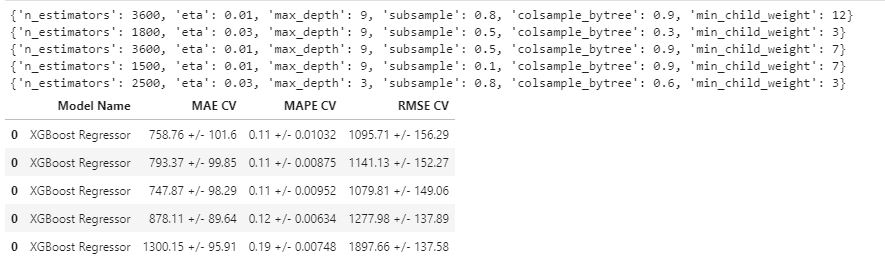

In [89]:
Image(r'Data\images\FINETUNING_RESULTS.JPG', width = 800, height = 600)

## 8.2 Final Model Tuned

In [90]:
param_tuned = {
        'n_estimators' : 3600,
        'eta' : 0.01,
        'max_depth' : 9,
        'subsample' : 0.5,
        'colsample_bytree' : 0.9,
        'min_child_weight' : 7}

In [91]:
# Model 
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                                   random_state=153,
                                   n_estimators = param_tuned['n_estimators'],
                                   eta = param_tuned['eta'],
                                   max_depth = param_tuned['max_depth'],
                                   subsample = param_tuned['subsample'],
                                   colsample_bytree = param_tuned['colsample_bytree'],
                                   min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

# Predict 
yhat_xgb_tuned = model_xgb_tuned.predict( x_test)

# Performance 
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,646.980631,0.09439,947.703464


# 9.0 Error Traduction

In [92]:
df9 = X_test[ selected_cols_full ].copy()

# Rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [93]:
# Sum of predictions
df9_sum_pred = df9[['store','predictions']].groupby('store').sum().reset_index()

# Include MAE e MAPE
df9_mae = df9[['store','sales', 'predictions']].groupby('store').apply(lambda x : mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0:'MAE'})
df9_mape = df9[['store','sales', 'predictions']].groupby('store').apply(lambda x : mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0:'MAPE'})

# Merge
df9_merge_mae_mape = pd.merge(df9_mae, df9_mape, how = 'inner', on= 'store')
df9_bp = pd.merge(df9_merge_mae_mape, df9_sum_pred, how='left', on='store' )

# Scenarios
df9_bp['worst_scenario'] = df9_bp['predictions'] - df9_bp['MAE']
df9_bp['best_scenario'] = df9_bp['predictions'] + df9_bp['MAE']

# Order columns
df9_bp = df9_bp[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [94]:
df9_bp.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,105680.351562,102295.881296,109064.821829,3384.470266,0.577793
908,909,231002.734375,223281.290442,238724.178308,7721.443933,0.517386
594,595,363711.875000,359238.871529,368184.878471,4473.003471,0.305043
875,876,201166.109375,197211.964854,205120.253896,3954.144521,0.299909
721,722,344493.687500,342731.587891,346255.787109,1762.099609,0.237723


<AxesSubplot:xlabel='store', ylabel='MAPE'>

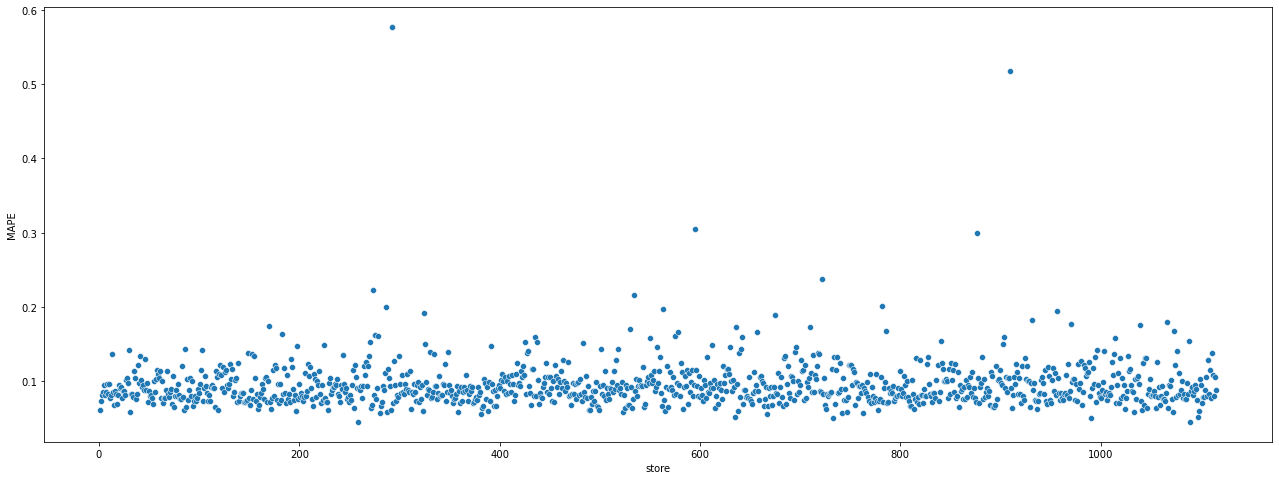

In [95]:
plt.figure(figsize=(22,8))
sns.scatterplot(x='store', y='MAPE', data=df9_bp)

## 9.2 Total Performance

In [96]:
df9_tp = df9_bp[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x : np.sum(x), axis=0).reset_index().rename(columns = {'index':'Scenarios' , 0:'Values'})
df9_tp['Values'] = df9_tp['Values'].map('R${:,.2f}'.format)

In [97]:
df9_tp

,Scenarios,Values
0,predictions,"R$283,903,744.00"
1,worst_scenario,"R$283,178,512.42"
2,best_scenario,"R$284,628,975.21"


## 9.3 Machine Learning Performance

In [98]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['sales'] / df9['predictions']

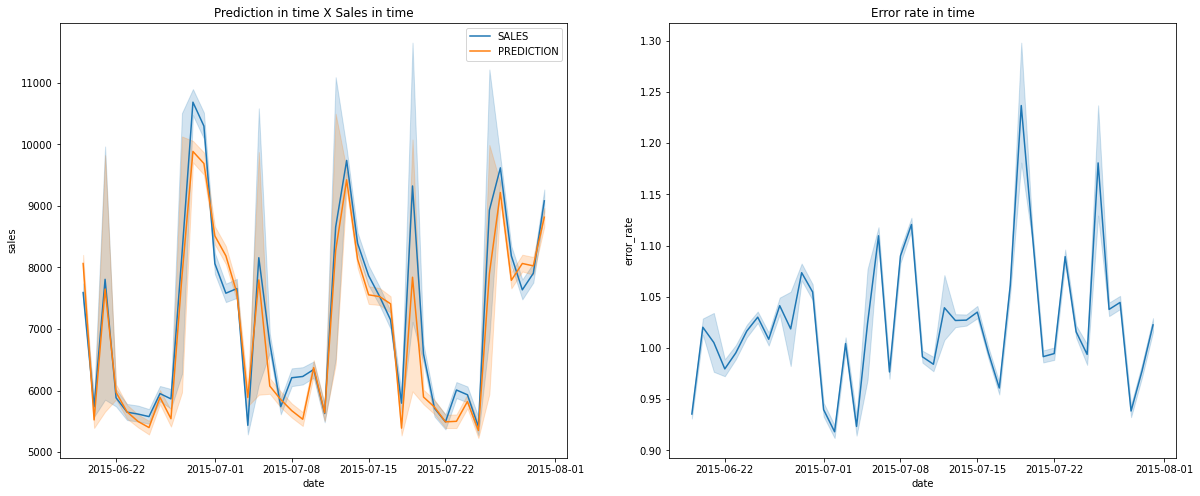

In [99]:
plt.figure(figsize=(20,8))


plt.subplot(1,2,1)
plt.title('Prediction in time X Sales in time')
sns.lineplot( x='date', y='sales', data=df9, label ='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label ='PREDICTION' )

plt.subplot(1,2,2)
plt.title('Error rate in time')
sns.lineplot(x='date', y='error_rate', data=df9);

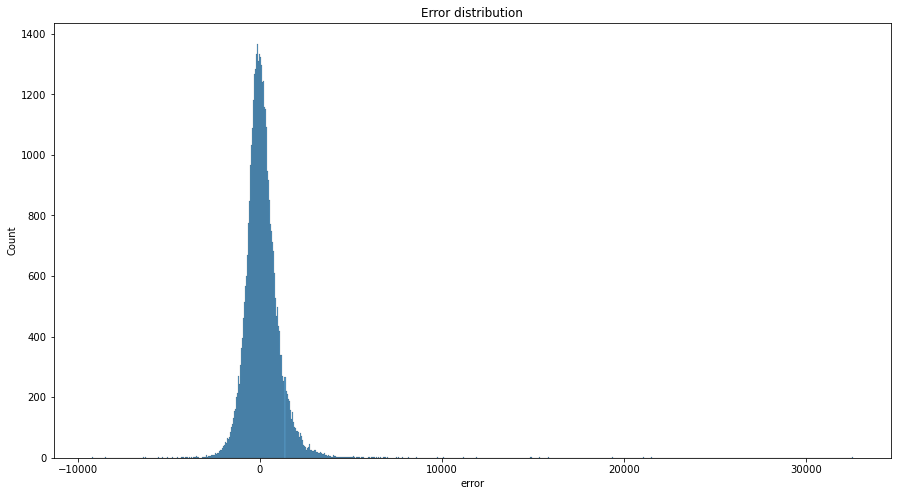

In [100]:
plt.figure(figsize=(15,8))
plt.title('Error distribution')
sns.histplot(df9['error']);

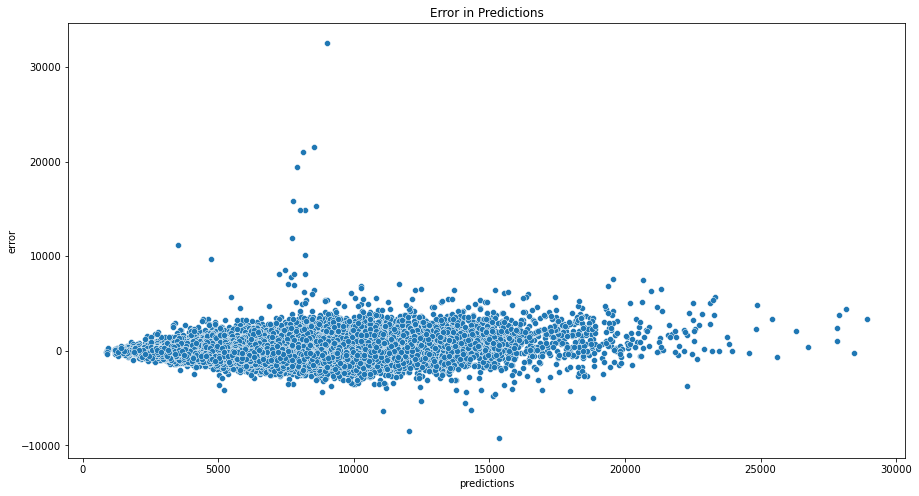

In [101]:
plt.figure(figsize=(15,8))
plt.title('Error in Predictions')
sns.scatterplot(x= 'predictions', y='error', data=df9);

# 10.0 Deploy Model to Production

In [102]:
# Saved Trained Model 
pickle.dump( xgb_result_tuned, open (r'Data\model\model_rossmann.pkl', 'wb') )

## 10.1 Rossmann class

In [103]:
import pickle
import pandas as pd
import numpy as np
import math 
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.competition_distance_scaler    = pickle.load(open(r'Data\parameter\competition_distance_scaler.pkl' , 'rb'))
        self.competition_since_month_scaler = pickle.load(open(r'Data\parameter\competition_since_month_scaler.pkl','rb'))
        self.promo_time_week_scaler         = pickle.load(open(r'Data\parameter\promo_time_week_scaler.pkl','rb'))
        self.year_scaler                    = pickle.load(open(r'Data\parameter\year_scaler.pkl','rb'))
        self.store_type_scaler              = pickle.load(open(r'Data\parameter\store_type_scaler.pkl','rb'))
    
    
    def data_cleaning (self, df1):
        ## 1.1 Rename Columns
        name_col_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
               'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
               'CompetitionDistance', 'CompetitionOpenSinceMonth',
               'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
               'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        name_col_new = list(map(snakecase,name_col_old))

        df1.columns = name_col_new

        ## 1.3 Data Types
        #Change date type from object to datatime
        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5 Fillout NA
        #CompetitionDistance 
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x :200000.0 if math.isnan(x) else x) 

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x :x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)

        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x :x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)

        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x :x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)

        #promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x :x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)

        #promo_interval
        month_map = {1:'Jan' , 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep' , 10:'Oct', 11:'Nov', 12:'Dez'}
        df1['promo_interval'] = df1['promo_interval'].fillna(0)
        df1['month_map'] = df1['date'].dt.month.map(month_map) 
        df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x : 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        ## 1.6 Change Types
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
        return df1

    def feature_engineering (self, df2):
        ## 2.3 Feature Engineering
        # Year
        df2['year'] = df2['date'].dt.year

        # Month
        df2['month'] = df2['date'].dt.month

        # Day
        df2['day'] = df2['date'].dt.day

        # Week of the year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # Year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # Competition since
        df2['competition_since']=df2.apply(lambda x : datetime.datetime(year= x['competition_open_since_year'], month= x['competition_open_since_month'], day=1), axis=1)
        df2['competition_since_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype(int)


        # Promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x : datetime.datetime.strptime(x +'-1','%Y-%W-%w') - datetime.timedelta( days= 7))
        df2['promo_time_week'] = ((df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # Assortment
        df2['assortment'] = df2['assortment'].apply(lambda x : 'basic' if x == 'a'  else 'extra' if x == 'b' else 'extended')

        # State holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x : 'public_holiday' if x == 'a' else 'easter_holiday'if x == 'b' else 'chirstmax' if x =='c' else 'regular_day')
        
        
        ## 3.1 Row filtering
        df2 = df2(df2['open'] != 0)

        ## 3.2 Features selection
        drop_cols = ['open','promo_interval','month_map']
        df2 = df2.drop(drop_cols, axis=1)

        return df2
    
    def data_preparation (self, df5):

        ## 5.2 Rescaling
        # Competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values)

        # Competition since month
        df5['competition_since_month'] = self.competition_since_month_scaler.fit_transform(df5[['competition_since_month']].values)

        # Promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        # Year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)


        ### 5.3.1 Encoding
        # State Holiday - One hot encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'],columns=['state_holiday'])


        # Store type - Label encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        # Assortment - Ordinal encoding
        assortment_dict={'basic' : 1 , 'extra' : 2 , 'extended' : 3 }
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.3 Nature Transformation

        # Transform linear variable into cyclic variables
        # Day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x : np.sin(x * (2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x : np.cos(x * (2. * np.pi/7)))

        # Month
        df5['month_sin'] = df5['month'].apply(lambda x : np.sin(x * (2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x : np.cos(x * (2. * np.pi/12)))

        # Day
        df5['day_sin'] = df5['day'].apply(lambda x : np.sin(x * (2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x : np.cos(x * (2. * np.pi/30)))

        # Week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x : np.sin(x * (2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x : np.cos(x * (2. * np.pi/52)))
        
        selected_list = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2','promo2_since_week', 
                         'promo2_since_year', 'competition_since_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_cos', 'day_sin', 'day_cos', 
                         'week_of_year_cos','week_of_year_sin','month_sin']
        
        return df5[selected_list]  
    
    def get_prediction(self, model, original_data, test_data):
        # Prediction
        pred = model.predict(test_data)
        
        # Join pred into original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', data_format='iso' )
        

## 10.2 API Handler

In [104]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# Loading model
model = pickle.load(open(r'Data\model\model_rossmann.pkl', 'rb'))

# Initialize API
app = Flask (__name__)

@app.route(r'Data\predict', methods=['POST'] )

def rossmann_predict():
    test_jason = request.get_jason()
    
    if test_jason: # Have data
        if isinstance(teste_json,dict): # Unique examples
            test_raw = pd.DataFrame(test_json, index=[0] )
        else: # Multiple examples
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys())
    
        # Instanciate Rossmann class
        pipeline = Rossmann()
        
        # Data Cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # Feature Engineering
        df2 = pipeline.feature_engineering(df1)
        
        # Data Preparation
        df3 = pipeline.data_preparation(df2)
        
        # Prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    
    else:
        return Response ('{}', status=200 , mimetype='application/json')


if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [105]:
#loading test dataset
df10 = pd.read_csv(r'Data\data\test.csv')

In [106]:
# Merge datasets
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# Choose store for prediction
df_test = df_test[df_test['Store']==22]

#Remove closed days
df_test = df_test[df_test['Open'] !=0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [107]:
# Convert Dataset to Json
data = json.dumps(df_test.to_dict(orient='records'))

In [113]:
# API Call
url = 'http://0.0.0.0:5000/rossmann/predict'
header ={'Content-type':'application/json'}
data = data

requests.post( url,data=data, headers = header )
print('Status Code{}'.format(r.status_code))


ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=5000): Max retries exceeded with url: /rossmann/predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000013992990BB0>: Failed to establish a new connection: [WinError 10049] O endereço solicitado não é válido no contexto'))